<a href="https://colab.research.google.com/github/g270535-art/Simulacoes_IC_PIBIC2025/blob/main/Simula%C3%A7%C3%B5es_IC_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Black-Scholes

In [20]:
# -------------------------------
# PARTE 3: BLACK-SCHOLES
# -------------------------------
def black_scholes(S, K, r, T, sigma, tipo='call'):
    """
    Calcula o preço de uma opção europeia (call ou put) usando o modelo de Black-Scholes.

    Parâmetros:
    S     : preço atual do ativo subjacente
    K     : preço de exercício (strike)
    r     : taxa de juros livre de risco
    T     : tempo até o vencimento (em anos)
    sigma : volatilidade anual do ativo
    tipo  : 'call' ou 'put'

    Retorna:
    Preço da opção europeia
    """

    if T <= 0:
        raise ValueError("O tempo até o vencimento T deve ser positivo.")

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    if tipo == 'call':
        return call_price
    elif tipo == 'put':
        # Paridade put-call
        put_price = call_price - S + K * np.exp(-r * T)
        return put_price
    else:
        raise ValueError("Tipo inválido. Use 'call' ou 'put'.")

#Opções Europeias

##Estudo passos

In [3]:
# Parâmetros
S0 = 50
K = 45
vol = 0.4
r = 0.1
#N = 1000
#M = 1000
T = 30/252

In [22]:
print(f"Preço da opção (Black-Scholes):  R$ {black_scholes(S0, K, r, T, vol, tipo='call'):.3f}")

Preço da opção (Black-Scholes):  R$ 6.248


In [24]:
# @title Códigos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def gbm_solution(X0, mu, sigma, T, n, dB=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    dt = T / n
    if dB is None:
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(1, n))

    passos = np.linspace(0, T, n + 1)
    B = np.insert(np.cumsum(dB[0]), 0, 0)
    trajetoria = X0 * np.exp((mu - 0.5 * sigma**2) * passos + sigma * B)
    return passos, trajetoria

# Funções do GBM
def a(x): return r * x
def b(x): return vol * x
def db(x): return vol * np.ones_like(x)

# Métodos numéricos
def euler_maruyama(a, b, X0, T, n, n_paths=1, seed=None, dB=None):
    if seed: np.random.seed(seed)
    dt = T / n
    passos = np.linspace(0, T, n + 1)
    trajetorias = np.zeros((n_paths, n + 1))
    trajetorias[:, 0] = X0
    if dB is None:
        #dB = np.random.normal(0, np.sqrt(dt), size=(n_paths, n))
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))
    for i in range(n):
        trajetorias[:, i + 1] = trajetorias[:, i] + a(trajetorias[:, i]) * dt + b(trajetorias[:, i]) * dB[:, i]
    return passos, trajetorias

def milstein(a, b, db, X0, T, n, n_paths=1, seed=None, dB=None):
    if seed: np.random.seed(seed)
    dt = T / n
    passos = np.linspace(0, T, n + 1)
    trajetorias = np.zeros((n_paths, n + 1))
    trajetorias[:, 0] = X0
    if dB is None:
        #dB = np.random.normal(0, np.sqrt(dt), size=(n_paths, n))
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))
    for i in range(n):
        trajetorias[:, i + 1] = (
            trajetorias[:, i] +
            a(trajetorias[:, i]) * dt +
            b(trajetorias[:, i]) * dB[:, i] +
            0.5 * b(trajetorias[:, i]) * db(trajetorias[:, i]) * (dB[:, i]**2 - dt)
        )
    return passos, trajetorias

def tabela_precos_monte_carlo_passos(S0, K, T, r, vol, metodo_nome, metodo_func, seed=None):
    Ns = [10, 100, 1000]      # Número de passos
    Ms = [100000]             # Número de simulações
    resultados = {}

    for N in Ns:
        linha = {}
        for M in Ms:
            # Fixar o seed antes de gerar incrementos para garantir repetibilidade
            if seed is not None:
                np.random.seed(seed)

            dt = T / N
            dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))

            if metodo_nome == "gbm":
                trajetorias = np.zeros((M, N + 1))
                for i in range(M):
                    _, traj = gbm_solution(S0, r, vol, T, N, dB[i:i+1], seed=seed)
                    trajetorias[i, :] = traj
            elif metodo_nome == "euler":
                _, trajetorias = metodo_func(a, b, S0, T, N, M, dB=dB, seed=seed)
            elif metodo_nome == "milstein":
                _, trajetorias = metodo_func(a, b, db, S0, T, N, M, dB=dB, seed=seed)
            else:
                raise ValueError("Método inválido.")

            payoff = np.maximum(trajetorias[:, -1] - K, 0)
            preco = np.exp(-r * T) * np.mean(payoff)
            erro = np.exp(-r * T) * np.std(payoff) / np.sqrt(M)
            linha[M] = f"{preco:.3f} ± {erro:.3f}"
        resultados[N] = linha

    df_resultado = pd.DataFrame(resultados).T
    df_resultado.index.name = 'Passos (N)'
    df_resultado.columns = [f"Simulações (M = {m})" for m in Ms]

    print(f"\n📊 Tabela para método: {metodo_nome.upper()} (seed={seed})")
    display(df_resultado)

In [29]:
tabela_precos_monte_carlo_passos(S0, K, T, r, vol, "gbm", gbm_solution,4)
tabela_precos_monte_carlo_passos(S0, K, T, r, vol, "euler", euler_maruyama,5)
tabela_precos_monte_carlo_passos(S0, K, T, r, vol, "milstein", milstein,8)


📊 Tabela para método: GBM (seed=4)


,Simulações (M = 100000)
Passos (N),
10,6.198 ± 0.019
100,6.227 ± 0.019
1000,6.237 ± 0.019



📊 Tabela para método: EULER (seed=5)


,Simulações (M = 100000)
Passos (N),
10,6.261 ± 0.019
100,6.262 ± 0.019
1000,6.254 ± 0.019



📊 Tabela para método: MILSTEIN (seed=8)


,Simulações (M = 100000)
Passos (N),
10,6.264 ± 0.019
100,6.223 ± 0.019
1000,6.235 ± 0.019


##Estudo trajetórias

In [11]:
# Parâmetros
S0 = 50
K = 45
vol = 0.4
r = 0.1
T = 30/252

In [21]:
print(f"Preço da opção (Black-Scholes):  R$ {black_scholes(S0, K, r, T, vol, tipo='call'):.3f}")

Preço da opção (Black-Scholes):  R$ 6.248


In [16]:
# @title Códigos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def gbm_solution(X0, mu, sigma, T, n, dB=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    dt = T / n
    if dB is None:
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(1, n))

    passos = np.linspace(0, T, n + 1)
    B = np.insert(np.cumsum(dB[0]), 0, 0)
    trajetoria = X0 * np.exp((mu - 0.5 * sigma**2) * passos + sigma * B)
    return passos, trajetoria

# Funções do GBM
def a(x): return r * x
def b(x): return vol * x
def db(x): return vol * np.ones_like(x)

# Métodos numéricos
def euler_maruyama(a, b, X0, T, n, n_paths=1, seed=None, dB=None):
    if seed: np.random.seed(seed)
    dt = T / n
    passos = np.linspace(0, T, n + 1)
    trajetorias = np.zeros((n_paths, n + 1))
    trajetorias[:, 0] = X0
    if dB is None:
        #dB = np.random.normal(0, np.sqrt(dt), size=(n_paths, n))
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))
    for i in range(n):
        trajetorias[:, i + 1] = trajetorias[:, i] + a(trajetorias[:, i]) * dt + b(trajetorias[:, i]) * dB[:, i]
    return passos, trajetorias

def milstein(a, b, db, X0, T, n, n_paths=1, seed=None, dB=None):
    if seed: np.random.seed(seed)
    dt = T / n
    passos = np.linspace(0, T, n + 1)
    trajetorias = np.zeros((n_paths, n + 1))
    trajetorias[:, 0] = X0
    if dB is None:
        #dB = np.random.normal(0, np.sqrt(dt), size=(n_paths, n))
        dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))
    for i in range(n):
        trajetorias[:, i + 1] = (
            trajetorias[:, i] +
            a(trajetorias[:, i]) * dt +
            b(trajetorias[:, i]) * dB[:, i] +
            0.5 * b(trajetorias[:, i]) * db(trajetorias[:, i]) * (dB[:, i]**2 - dt)
        )
    return passos, trajetorias

def tabela_precos_monte_carlo(S0, K, T, r, vol, metodo_nome, metodo_func, seed=None):
    Ns = [1000]      # Número de passos
    Ms = [100, 1000, 10000, 100000]             # Número de trajetórias
    resultados = {}

    for N in Ns:
        linha = {}
        for M in Ms:
            # Fixar o seed antes de gerar incrementos para garantir repetibilidade
            if seed is not None:
                np.random.seed(seed)

            dt = T / N
            dB = np.sqrt(dt) * np.random.normal(0, 1, size=(M, N))

            if metodo_nome == "gbm":
                trajetorias = np.zeros((M, N + 1))
                for i in range(M):
                    _, traj = gbm_solution(S0, r, vol, T, N, dB[i:i+1], seed=seed)
                    trajetorias[i, :] = traj
            elif metodo_nome == "euler":
                _, trajetorias = metodo_func(a, b, S0, T, N, M, dB=dB, seed=seed)
            elif metodo_nome == "milstein":
                _, trajetorias = metodo_func(a, b, db, S0, T, N, M, dB=dB, seed=seed)
            else:
                raise ValueError("Método inválido.")

            payoff = np.maximum(trajetorias[:, -1] - K, 0)
            preco = np.exp(-r * T) * np.mean(payoff)
            erro = np.exp(-r * T) * np.std(payoff) / np.sqrt(M)
            linha[M] = f"{preco:.3f} ± {erro:.3f}"
        resultados[N] = linha

    df_resultado = pd.DataFrame(resultados).T
    df_resultado.index.name = 'Passos (N)'
    df_resultado.columns = [f"Simulações (M = {m})" for m in Ms]

    print(f"\n📊 Tabela para método: {metodo_nome.upper()} (seed={seed})")
    display(df_resultado)


In [ ]:
# @title Código antitético
def monte_carlo_antitetico_call(S0, K, r, T, vol, N, M, seed=None):
    """
    Estima o valor de uma opção de compra europeia via simulação de Monte Carlo
    utilizando variáveis antitéticas para redução da variância.

    Parâmetros:
        S0    : Preço inicial do ativo
        K     : Preço de exercício
        r     : Taxa de juros livre de risco (contínua)
        T     : Tempo até o vencimento (em anos)
        vol   : Volatilidade anual
        N     : Número de passos de tempo
        M     : Número de simulações (pares antitéticos)
        seed  : Semente para reprodutibilidade (opcional)

    Retorna:
        C0      : Valor estimado da opção
        SE_a    : Erro padrão da estimativa
    """

    # Controle de aleatoriedade
    if seed is not None:
        np.random.seed(seed)

    dt = T / N
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    lnS = np.log(S0)

    sum_CT_a = 0
    sum_CT2_a = 0

    for i in range(M):
        lnSt1 = lnS
        lnSt2 = lnS
        for j in range(N):
            Z = np.random.normal()
            lnSt1 += nudt + volsdt * Z
            lnSt2 += nudt - volsdt * Z  # Antitético

        ST1 = np.exp(lnSt1)
        ST2 = np.exp(lnSt2)

        CT1 = max(0, ST1 - K)
        CT2 = max(0, ST2 - K)

        CT_avg = 0.5 * (CT1 + CT2)

        sum_CT_a += CT_avg
        sum_CT2_a += CT_avg ** 2

    C0 = np.exp(-r * T) * sum_CT_a / M
    sigma_a = np.sqrt((sum_CT2_a - (sum_CT_a ** 2) / M) * np.exp(-2 * r * T) / (M - 1))
    SE_a = sigma_a / np.sqrt(M)

    return C0, SE_a

def tabela_precos_antitetico(S0, K, T, r, vol, seed=None):
    Ns = [1000]  # Número de passos
    Ms = [100, 1000, 10000, 100000]  # Número de simulações (pares antitéticos)
    resultados = {}

    for N in Ns:
        linha = {}
        for M in Ms:
            preco, erro = monte_carlo_antitetico_call(S0, K, r, T, vol, N, M, seed=seed)
            linha[M] = f"{preco:.3f} ± {erro:.3f}"
        resultados[N] = linha

    df_resultado = pd.DataFrame(resultados).T
    df_resultado.index.name = 'Passos (N)'
    df_resultado.columns = [f"Simulações (M = {m})" for m in Ms]

    print(f"\n📊 Tabela para método: VARIÁVEIS ANTITÉTICAS (seed={seed})")
    display(df_resultado)


In [ ]:
tabela_precos_monte_carlo(S0, K, T, r, vol, "gbm", gbm_solution)
tabela_precos_antitetico(S0, K, T, r, vol)
tabela_precos_monte_carlo(S0, K, T, r, vol, "euler", euler_maruyama)
tabela_precos_monte_carlo(S0, K, T, r, vol, "milstein", milstein)


📊 Tabela para método: GBM


,Simulações (M = 100),Simulações (M = 1000),Simulações (M = 10000),Simulações (M = 100000)
Passos (N),,,,
1000,6.0242 ± 0.6179,6.1345 ± 0.1854,6.2731 ± 0.0599,6.2584 ± 0.0189



📊 Tabela para método: VARIÁVEIS ANTITÉTICAS


,Simulações (M = 100),Simulações (M = 1000),Simulações (M = 10000),Simulações (M = 100000)
Passos (N),,,,
1000,6.4436 ± 0.1979,6.3149 ± 0.0610,6.2586 ± 0.0187,6.2506 ± 0.0058



📊 Tabela para método: EULER


,Simulações (M = 100),Simulações (M = 1000),Simulações (M = 10000),Simulações (M = 100000)
Passos (N),,,,
1000,6.3280 ± 0.6289,6.6440 ± 0.1941,6.2426 ± 0.0599,6.2460 ± 0.0190



📊 Tabela para método: MILSTEIN


,Simulações (M = 100),Simulações (M = 1000),Simulações (M = 10000),Simulações (M = 100000)
Passos (N),,,,
1000,6.0610 ± 0.6249,6.1701 ± 0.1917,6.2416 ± 0.0601,6.2782 ± 0.0190


#Opções americans

##Códigos

In [70]:
import numpy as np
import pandas as pd
from numpy.polynomial.laguerre import lagval

# ---------- Funções auxiliares ----------
def simular_precos(S0, r, sigma, T, passos, caminhos, seed=None):
    """Simula caminhos de preços usando GBM com seed"""
    if seed is not None:
        np.random.seed(seed)
    dt = T / passos
    precos = np.zeros((caminhos, passos + 1))
    precos[:, 0] = S0
    for t in range(1, passos + 1):
        z = np.random.standard_normal(caminhos)
        precos[:, t] = precos[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return precos, dt

def base_laguerre(x, grau):
    return np.array([lagval(x, [0]*i + [1]) for i in range(grau + 1)]).T

# ---------- Função de precificação ----------
def precificar_opcao(preco_inicial, strike, taxa_juros, tempo_total, volatilidade,
                     passos, caminhos, grau_base, tipo, seed=None):
    """Calcula o preço de uma opção americana via método de Longstaff-Schwartz.

    Parâmetros:
        tipo: 'call' ou 'put'
        seed: número inteiro para tornar a simulação reproduzível
    """
    # Passa a seed para a simulação de preços
    precos, dt = simular_precos(preco_inicial, taxa_juros, volatilidade,
                                tempo_total, passos, caminhos, seed=seed)

    valor_opcao = np.zeros_like(precos)

    # Payoff no vencimento
    if tipo.lower() == "call":
        valor_opcao[:, -1] = np.maximum(precos[:, -1] - strike, 0)
    elif tipo.lower() == "put":
        valor_opcao[:, -1] = np.maximum(strike - precos[:, -1], 0)
    else:
        raise ValueError("O parâmetro 'tipo' deve ser 'call' ou 'put'.")

    # Loop de trás para frente no tempo
    for t in range(passos - 1, 0, -1):
        if tipo.lower() == "call":
            payoff = np.maximum(precos[:, t] - strike, 0)
        else:
            payoff = np.maximum(strike - precos[:, t], 0)

        em_dinheiro = payoff > 0
        base = base_laguerre(precos[em_dinheiro, t], grau_base)
        retorno_futuro = valor_opcao[em_dinheiro, t + 1] * np.exp(-taxa_juros * dt)

        # Regressão para estimar valor de continuação
        coeficientes = np.linalg.lstsq(base, retorno_futuro, rcond=None)[0]
        valor_estimado = base_laguerre(precos[:, t], grau_base) @ coeficientes

        # Decisão: exercer ou continuar
        exercem = payoff > valor_estimado
        valor_opcao[exercem, t] = payoff[exercem]
        valor_opcao[~exercem, t] = valor_opcao[~exercem, t + 1] * np.exp(-taxa_juros * dt)

    # Cálculo do valor presente esperado
    fluxos_de_caixa = np.zeros(caminhos)
    for i in range(caminhos):
        for t in range(1, passos + 1):
            preco = precos[i, t]
            if tipo.lower() == "put":
                payoff = max(strike - preco, 0)
            else:
                payoff = max(preco - strike, 0)

            valor_lsm = valor_opcao[i, t]
            if payoff > 0 and valor_lsm == payoff:
                fluxos_de_caixa[i] = payoff * np.exp(-taxa_juros * dt * t)
                break

    return np.mean(fluxos_de_caixa), np.std(fluxos_de_caixa)




##Escolha da base

In [71]:
# ---------- Simulação pedida ----------
import numpy as np
import pandas as pd

S0 = 30
K = 30
r = 0.05
sigma = 0.2
T = 1
passos = 50
caminhos = 500
tipo = "call"
bases = [2, 3, 4, 5]
repeticoes = 500

resultados = []

for grau in bases:
    precos = []
    for i in range(repeticoes):
        media, desvio = precificar_opcao(S0, K, r, T, sigma, passos, caminhos,
                                         grau, tipo, seed=i)
        precos.append(media)
    resultados.append({"Base": grau, "Preço Médio": np.mean(precos)})

df_resultados = pd.DataFrame(resultados)
df_resultados


,Base,Preço Médio
0,2,3.177055
1,3,3.180458
2,4,3.196461
3,5,3.202816


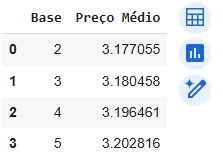

In [47]:
print(f"Preço da opção (Black-Scholes):  R$ {black_scholes(S0, K, r, T, sigma, tipo='call'):.3f}")

Preço da opção (Black-Scholes):  R$ 3.135


##Precificação

In [72]:
dados = {'P0':[30, 30, 30, 28, 28, 28, 32, 32, 32],
         'K':[30]*9,
         'r':[0.05]*9,
         't':[1.0]*9,
         'σ':[0.1, 0.2, 0.4, 0.1, 0.2, 0.4, 0.1, 0.2, 0.4],
         'Passos':[50]*9,
         'Caminhos':[100000]*9,
         'grau_base':[4]*9,
         'tipo':['put']*9,
         'LSM':[None]*9,
         'Desvio': [None]*9}

In [74]:
resultados = []
desvios = []

for i in range(len(dados['P0'])):
    media, desvio = precificar_opcao(
        dados['P0'][i],
        dados['K'][i],
        dados['r'][i],
        dados['t'][i],
        dados['σ'][i],
        dados['Passos'][i],
        dados['Caminhos'][i],
        dados['grau_base'][i],
        dados['tipo'][i],
        seed=1  # opcional, para reprodutibilidade
    )
    resultados.append(round(media, 4))
    desvios.append(round(desvio, 4))

dados['LSM'] = resultados
dados['Desvio'] = desvios

In [75]:
df = pd.DataFrame(dados)
from google.colab import data_table
data_table.DataTable(df)

,P0,K,r,t,σ,Passos,Caminhos,grau_base,tipo,LSM,Desvio
0,30,30,0.05,1.0,0.1,50,100000,4,put,0.7286,0.8998
1,30,30,0.05,1.0,0.2,50,100000,4,put,1.8261,2.1308
2,30,30,0.05,1.0,0.4,50,100000,4,put,4.0942,4.3604
3,28,30,0.05,1.0,0.1,50,100000,4,put,1.9928,0.6244
4,28,30,0.05,1.0,0.2,50,100000,4,put,2.8099,2.3372
5,28,30,0.05,1.0,0.4,50,100000,4,put,4.9619,4.5988
6,32,30,0.05,1.0,0.1,50,100000,4,put,0.2226,0.5531
7,32,30,0.05,1.0,0.2,50,100000,4,put,1.1451,1.8057
8,32,30,0.05,1.0,0.4,50,100000,4,put,3.3806,4.1301


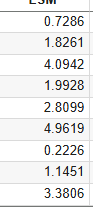

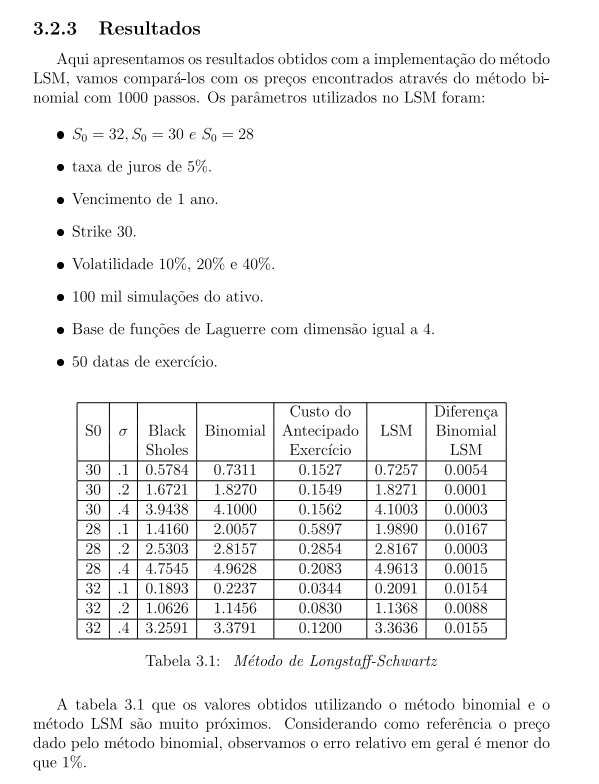